# Using ``SplitCPRegressor`` to get adaptative prediction intervals

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/exoplanets.ipynb)

In [1]:
install_mapie = True
if install_mapie:
    !pip install mapie

In [2]:
import warnings

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from mapie.calibrators import CustomCCP, GaussianCCP, PolynomialCCP
from mapie.calibrators.ccp import CCPCalibrator
from mapie.conformity_scores import AbsoluteConformityScore
from mapie.regression import MapieQuantileRegressor, MapieRegressor, SplitCPRegressor
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.model_selection import PredefinedSplit, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings("ignore")

random_state = 1
np.random.seed(random_state)


## 1. Data generation

Let's start by creating some synthetic data with different domains and distributions to evaluate the adaptativity of the methods

- baseline distribution of ``x*sin(x)``
- Add noise :
    - between -1 and 0: uniform distribution of the points around the baseline
    - between 0 and 5: normal distribution with a noise value which increase with ``x``

In [3]:
ALPHA = 0.1

In [4]:
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

def get_1d_data_with_heteroscedastic_noise(
    funct, min_x, max_x, n_samples, noise, power
):
    """
    Generate 1D noisy data uniformely from the given function
    and standard deviation for the noise.
    """
    # np.random.seed(59)
    X = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X)

    y = (
        funct(X) +
        (np.random.normal(0, noise, len(X)) * ((X)/max_x)**power*max_x)+
        (np.random.uniform(-noise*3, noise*3, len(X))) * (X<0)
    )

    true_pi = np.hstack([x_sinx(X).reshape(-1, 1)]*2)
    true_pi[X<0,0] += noise*3*(1-ALPHA) 
    true_pi[X<0,1] -= noise*3*(1-ALPHA)
    true_pi[X>=0,0] += norm.ppf(1 - ALPHA/2)* noise * ((X[X>=0])/max_x)**power*max_x
    true_pi[X>=0,1] -= norm.ppf(1 - ALPHA/2)* noise * ((X[X>=0])/max_x)**power*max_x

    return X.reshape(-1, 1), y, true_pi


def generate_data(n_train=10000, n_test=4000, noise=0.8, power=2):
    X, y, true_pi = get_1d_data_with_heteroscedastic_noise(x_sinx, -1, 5, n_train + n_test, noise, power)
    indexes = list(range(len(X)))
    train_indexes = np.random.choice(indexes, n_train)
    indexes = list(set(indexes) - set(train_indexes))
    test_indexes = np.random.choice(indexes, n_test)
    
    return X[train_indexes,:], y[train_indexes], X[test_indexes,:], y[test_indexes], true_pi[train_indexes,:], true_pi[test_indexes,:]

In [5]:
X_train, y_train, X_test, y_test, train_pi, test_pi = generate_data()

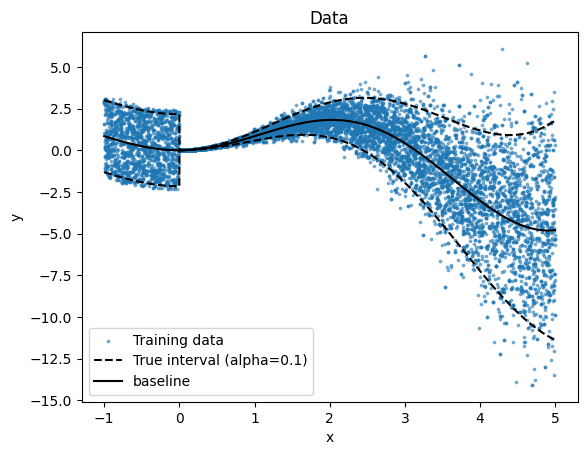

In [6]:
plt.scatter(X_train, y_train, color="C0", alpha=0.5, s=3, label="Training data")
sort_order = np.argsort(X_train[:,0])
x_sorted = X_train[sort_order,:]
plt.plot(x_sorted, train_pi[sort_order,0], "k--", label=f"True interval (alpha={ALPHA})")
plt.plot(x_sorted, train_pi[sort_order,1], "k--", linestyle='--')
plt.plot(x_sorted, x_sinx(x_sorted), "k-", label="baseline")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data")
plt.legend()
plt.show()

## Models : Polynomial regression

In [7]:
polynomial_degree = 4
quantile_estimator = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=polynomial_degree)),
        ("linear", QuantileRegressor(
                solver="highs",
                alpha=0,
        ))
    ]
)
estimator = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=polynomial_degree)),
        ("linear", LinearRegression())
    ]
)

## Creation of Mapie instances

We are going to test different methods : ``CV+``, ``CQR`` and ``CCP`` (with default parameters)

In [8]:
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=random_state)
train_index, _ = list(cv.split(X_train))[0]
test_fold = np.ones(len(X_train))
test_fold[train_index] = -1

pred_cv = PredefinedSplit(test_fold)

# # ================== Basic Split ==================
mapie_split = MapieRegressor(estimator, method="base", cv=pred_cv)
mapie_split.fit(X_train, y_train)
y_pred_split, y_pi_split = mapie_split.predict(X_test, alpha=ALPHA)

# ================== CV + ==================
# MapieRegressor defaults to method='plus' and cv=5
mapie_cv = MapieRegressor(estimator, cv=pred_cv)
mapie_cv.fit(X_train, y_train)
y_pred_cv, y_pi_cv = mapie_cv.predict(X_test, alpha=ALPHA)

# ================== CQR  ==================
mapie_cqr = MapieQuantileRegressor(quantile_estimator, alpha=ALPHA)
mapie_cqr.fit(X_train, y_train)
y_pred_cqr, y_pi_cqr = mapie_cqr.predict(X_test)

# ================== CCP  ==================
mapie_ccp = SplitCPRegressor(estimator, alpha=ALPHA, cv=pred_cv)
mapie_ccp.fit(X_train, y_train)
y_pred_ccp, y_pi_ccp = mapie_ccp.predict(X_test)

## Prediction intervals plotting and adaptativity comparison

In [9]:

def plot_subplot(ax, X, y, mapie, y_pred, upper_pi, lower_pi, color_rgb, show_transform=False, ax_transform = None):
    sort_order = np.argsort(X[:, 0])
    lw = 1
    color = mcolors.rgb2hex(color_rgb)
    x_test_sorted = X[sort_order]
    y_test_sorted = y[sort_order]
    y_pred_sorted = y_pred[sort_order]
    upper_pi_sorted = upper_pi[sort_order]
    lower_pi_sorted = lower_pi[sort_order]

    # Plot test data
    ax.scatter(x_test_sorted[:, 0], y_test_sorted, s=1, alpha=0.3, color='darkblue', label="Test Data")

    # Plot prediction
    ax.plot(x_test_sorted[:, 0], y_pred_sorted, lw=lw, color='black', label="Prediction")

    # Plot prediction interval
    ax.fill_between(x_test_sorted[:, 0], upper_pi_sorted, lower_pi_sorted, color=color, alpha=0.3, label="Prediction interval")

    # Plot upper and lower prediction intervals
    ax.plot(x_test_sorted[:, 0], upper_pi_sorted, lw=lw, color=color)
    ax.plot(x_test_sorted[:, 0], lower_pi_sorted, lw=lw, color=color)

    # Plot true prediction interval
    ax.plot(x_test_sorted[:, 0], test_pi[sort_order, 0], "--k", lw=lw*1.5, label='True PI')
    ax.plot(x_test_sorted[:, 0], test_pi[sort_order, 1], "--k", lw=lw*1.5)

    if show_transform and isinstance(mapie, SplitCPRegressor) and isinstance(mapie.calibrator_, CCPCalibrator):
        for calibrator in list(mapie.calibrator_.functions_) + [mapie.calibrator_]:
            if isinstance(calibrator, CCPCalibrator):
                if isinstance(calibrator, GaussianCCP):
                    sigmas = np.log(calibrator.sigmas_[:, 0])
                else:
                    sigmas = np.zeros(calibrator.n_out)
                for i, loc in enumerate(calibrator.points_):
                    ax_transform.plot(x_test_sorted[:, 0], calibrator.transform(x_test_sorted)[:, i], lw=lw,
                            color=color)

def need_transform(mapie):
    if not isinstance(mapie, SplitCPRegressor) or not isinstance(mapie.calibrator_, CCPCalibrator):
        return False
    for calibrator in list(mapie.calibrator_.functions_) + [mapie.calibrator_]:
        if isinstance(calibrator, CCPCalibrator):
            if isinstance(calibrator, GaussianCCP):
                return True
    return False

def plot_figure(mapies, y_preds, y_pis, titles, show_transform=False):
    cp = list(sns.color_palette())*10
    ncols = min(3, len(titles))
    nrows = int(np.ceil(len(titles) / ncols))
    ax_need_transform = np.zeros((nrows, ncols))
    if show_transform:    
        for i, mapie in enumerate(mapies):
            ax_need_transform[i//ncols, i%ncols] = need_transform(mapie)
            row_need_transform = np.max(ax_need_transform, axis=1)
        height_ratio = np.array([item for x in row_need_transform for item in ([3] if x == 0 else [3, 1])])
        fig, axes = plt.subplots(nrows=nrows + int(sum(row_need_transform)), ncols=ncols, figsize=(ncols*4, nrows*5), height_ratios=height_ratio)

        for ax in axes[np.where(height_ratio == 1)[0]-1, :].flatten():
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        transform_axes = np.full((nrows, ncols), None)
        transform_axes[row_need_transform==1, :] = axes[height_ratio==1, :]
        transform_axes = transform_axes.flatten()
        main_axes = axes[height_ratio==3, :].flatten()
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
        main_axes = axes.flatten()
        transform_axes = np.full(main_axes.shape, None)

    for i, (m_ax, t_ax, mapie, y_pred, y_pi, title) in enumerate(zip(main_axes, transform_axes, mapies, y_preds, y_pis, titles)):
        lower_bound = y_pi[:, 0, 0]
        upper_bound = y_pi[:, 1, 0]

        plot_subplot(m_ax, X_test, y_test, mapie, y_pred, upper_bound, lower_bound, cp[i], show_transform=ax_need_transform.flatten()[i], ax_transform=t_ax)
        m_ax.set_title(title)
        if i % 3 == 0:
            m_ax.set_ylabel('Y')
        if t_ax is not None:
            t_ax.set_title("Transformation")
            if i >= len(titles) - ncols:
                t_ax.set_xlabel('X')
        else:
            m_ax.set_xlabel('X')
        m_ax.legend()

    fig.tight_layout()
    plt.show()

def plot_widths(titles, y_pis):
    sort_order = np.argsort(X_test[:, 0])
    cp = list(sns.color_palette())*10
    plt.figure(figsize=(8, 6))
    for i, (title, pi) in enumerate(zip(titles, y_pis)):
        plt.plot(X_test[sort_order, 0], (pi[sort_order, 1, 0] - pi[sort_order, 0, 0]), lw=2, color=mcolors.rgb2hex(cp[i]), label=title)

    plt.title("Prediction interval width")
    plt.xlabel("X")
    plt.ylabel("Width")
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

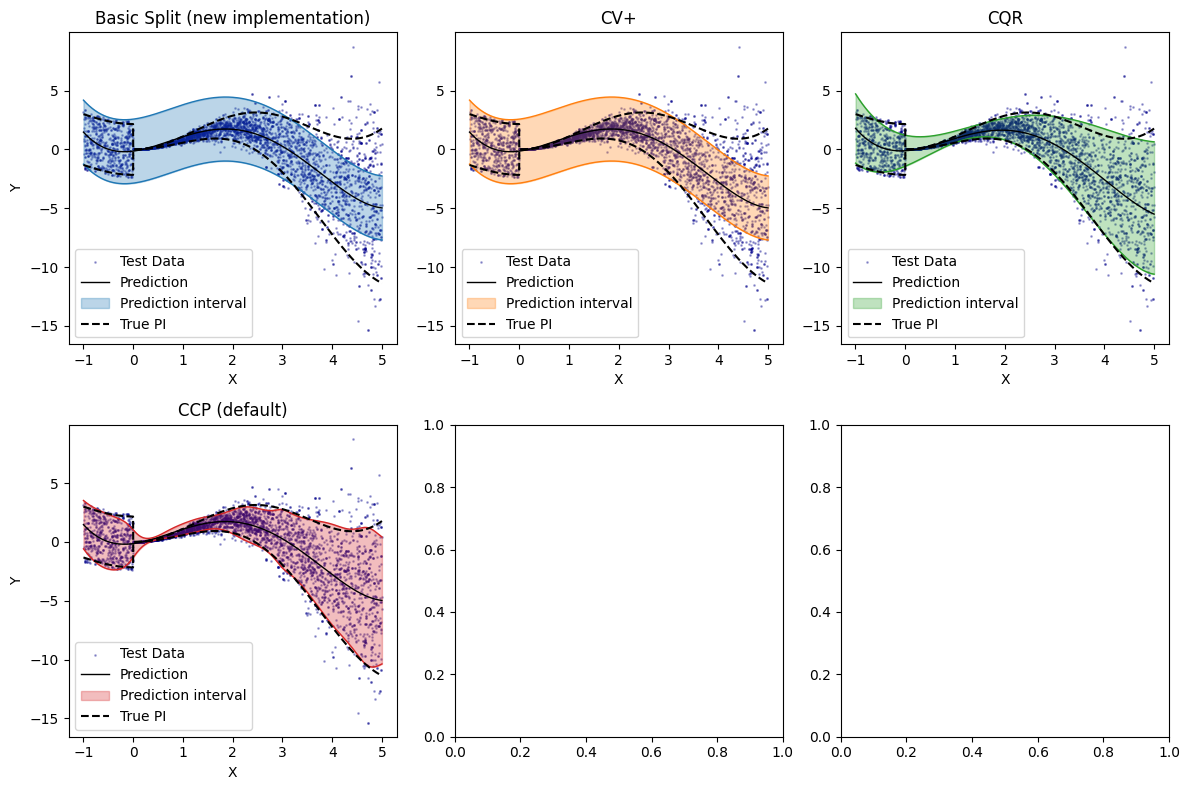

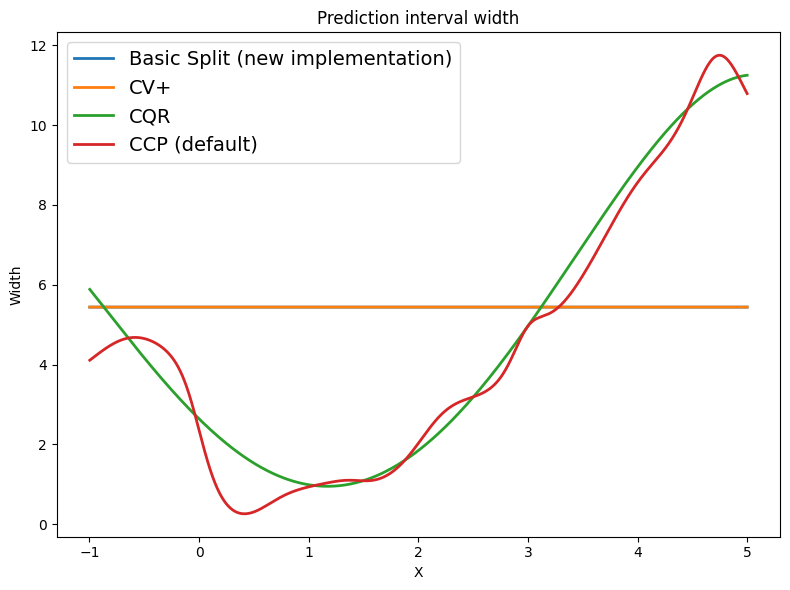

In [10]:
mapies = [mapie_split, mapie_cv, mapie_cqr, mapie_ccp]
y_preds = [y_pred_split, y_pred_cv, y_pred_cqr, y_pred_ccp]#_1, y_pred_ccp_2, y_pred_ccp_3]
y_pis = [y_pi_split, y_pi_cv, y_pi_cqr, y_pi_ccp]#_1, y_pi_ccp_2, y_pi_ccp_3]
titles = ["Basic Split (new implementation)", "CV+", "CQR", "CCP (default)"]# 1", "CCP 2", "CCP 3"]

plot_figure(mapies, y_preds, y_pis, titles)
plot_widths(titles, y_pis)

The ``SplitCPRegressor`` is a very adaptative method, even with default parameters values. If the dataset is more complex, the default parameters may not be enough to get the best performances. In this case, we can use more advanced settings, described below.

# How to improve the results ?
## 1/ How does the ``CCP`` method works ?

The CCP method is based on a function $\phi : X \to \phi(X) \in \R^d$

This vector $\phi(X)$ constitute features that should be able to represente the distribuion of the conformity scores, which is here (by default) the absolute residual: $\lvert y_{true} - y_{pred} \rvert$
#### Examples of basic $\phi$:
 - $\phi : X \to 1$, will try to estimate the absolute residual with a constant, and will results in a prediction interval of constant width (like the basic split CP)
 - $\phi : X \to (1, X)$, will result in a prediction interval of width equal to: a constant + a value proportional to the value of $X$ (it seems a good idea here, as the uncertainty increase with $X$)
 - $\phi : X \to (1, X^3)$, will result in a prediction interval of width equal to: a constant + a value proportional to the value of $X^3$ (it seems a good idea here, as the uncertainty increase with $X$)
 - $\phi : X \to y_{pred}$, will result in a prediction interval of width proportional to the prediction (It is sometime the case, when the uncertainty is proportionnal to the value).
 
   Note that using $\phi : X \to y_{pred}$ is somewhat similar to using a standard Split CP (``method="base"`` in ``MapieRegressor``) with a ``GammaConformityScore``.
 



#### Using custom definition:

In [11]:
calibrator1 = CustomCCP([lambda X: np.ones(len(X))])
calibrator1_bis = CustomCCP(bias=True)
# calibrator1_bis is equivalent to calibrator1, as bias=True adds a column of ones
calibrator2 = CustomCCP([lambda X: X], bias=True)
calibrator3 = CustomCCP([lambda X: X**3], bias=True)

#### Using ``PolynomialCCP`` class:

In [12]:
calibrator1 = PolynomialCCP(0)
calibrator2 = PolynomialCCP(1) # degree=1 is equivalent to degree=[0, 1]
calibrator3 = PolynomialCCP([0, 3]) # Warning, degree=2 is equivalent to degree=[0, 1, 2]
# Note: adding '0' in the 'degree' argument list is equivalent to having bias=True, as X^0=1

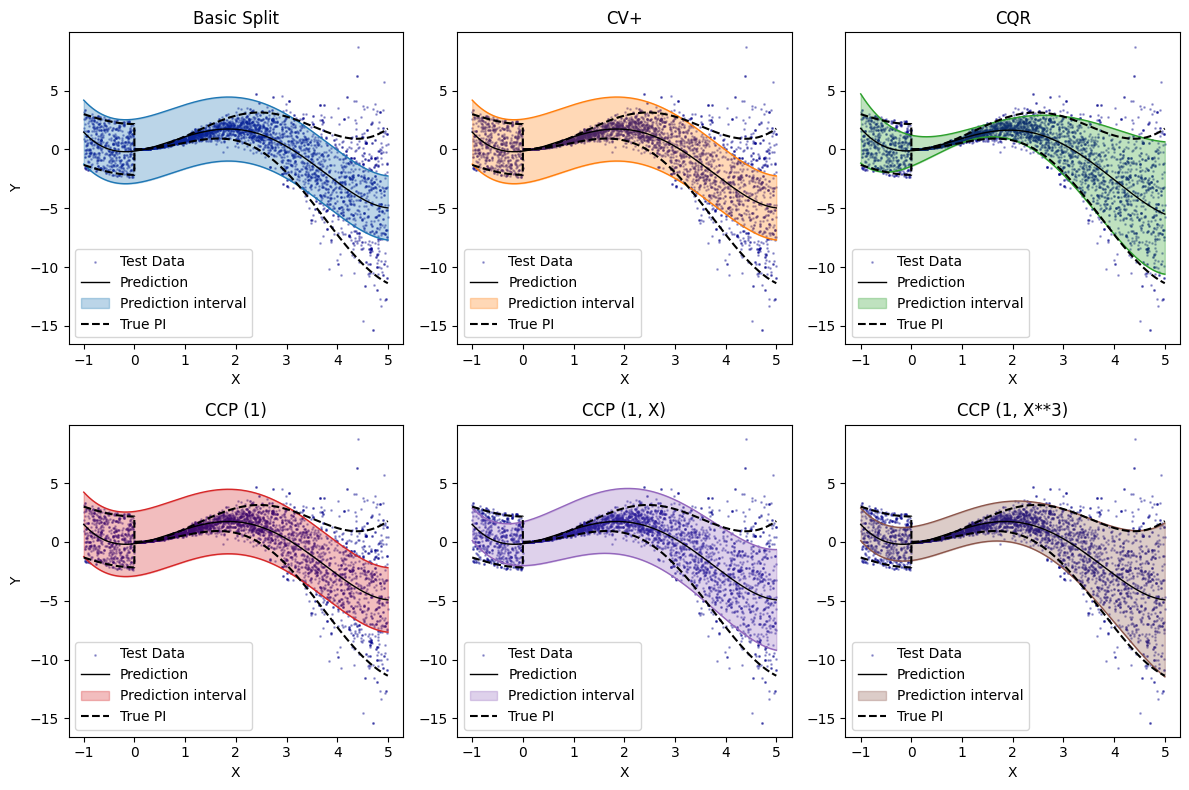

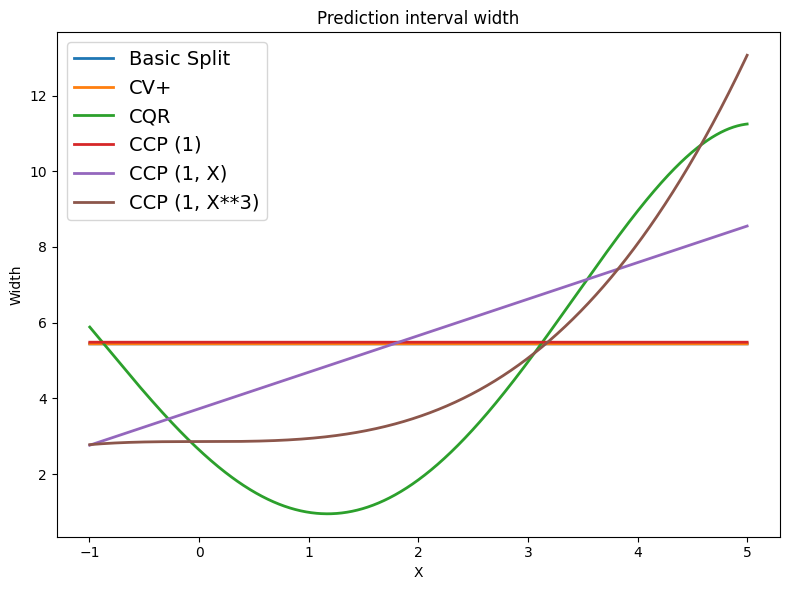

In [13]:
# # ================== CCP 1  ==================
mapie_ccp_1 = SplitCPRegressor(estimator, calibrator=calibrator1, alpha=ALPHA, random_state=random_state)
mapie_ccp_1.fit(X_train, y_train)
y_pred_ccp_1, y_pi_ccp_1 = mapie_ccp_1.predict(X_test)

# # ================== CCP 2  ==================
mapie_ccp_2 = SplitCPRegressor(estimator, calibrator=calibrator2, alpha=ALPHA, random_state=random_state)
mapie_ccp_2.fit(X_train, y_train)
y_pred_ccp_2, y_pi_ccp_2 = mapie_ccp_2.predict(X_test)

# # ================== CCP 3  ==================
mapie_ccp_3 = SplitCPRegressor(estimator, calibrator=calibrator3, alpha=ALPHA, random_state=random_state)
mapie_ccp_3.fit(X_train, y_train)
y_pred_ccp_3, y_pi_ccp_3 = mapie_ccp_3.predict(X_test)

mapies = [mapie_split, mapie_cv, mapie_cqr, mapie_ccp_1, mapie_ccp_2, mapie_ccp_3]
y_preds = [y_pred_split, y_pred_cv, y_pred_cqr, y_pred_ccp_1, y_pred_ccp_2, y_pred_ccp_3]
y_pis = [y_pi_split, y_pi_cv, y_pi_cqr, y_pi_ccp_1, y_pi_ccp_2, y_pi_ccp_3]
titles = ["Basic Split", "CV+", "CQR", "CCP (1)", "CCP (1, X)", "CCP (1, X**3)"]

plot_figure(mapies, y_preds, y_pis, titles)
plot_widths(titles, y_pis)

Note: The small width different between ``Basic Split`` and ``CCP 1`` is just because of the variance induced by the finite number of calibration and test points. The two values would both converge toward the same width if we would reproduce the experiment many times and average the results.

## 2/ Improve the performances using what we know about the data

To improve the results, we need to analyse the data and the conformity scores we chose (here, the absolute residuals).

1. We can see that the residuals increase with X for X > 0.

2. For X < 0, the points seem uniformly distributed around the base distribution.

In [14]:
calibrator1 = CustomCCP([lambda X: X < 0, lambda X: X >= 0])

calibrator2 = CustomCCP(
    [lambda X: X < 0, (lambda X: X >= 0)*PolynomialCCP(1)]
)

calibrator3 = CustomCCP(
    [
        (lambda X: X < 0)*PolynomialCCP(5),
        (lambda X: X >= 0)*PolynomialCCP(5)
    ]
)

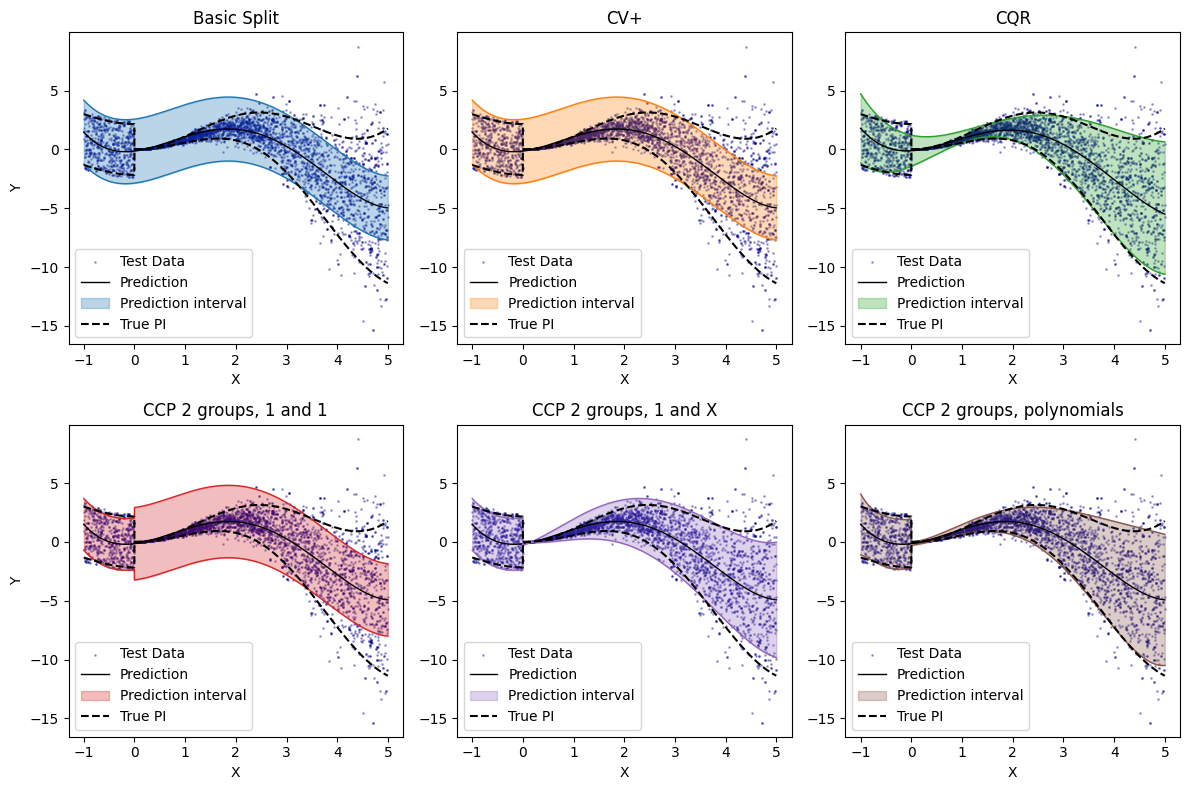

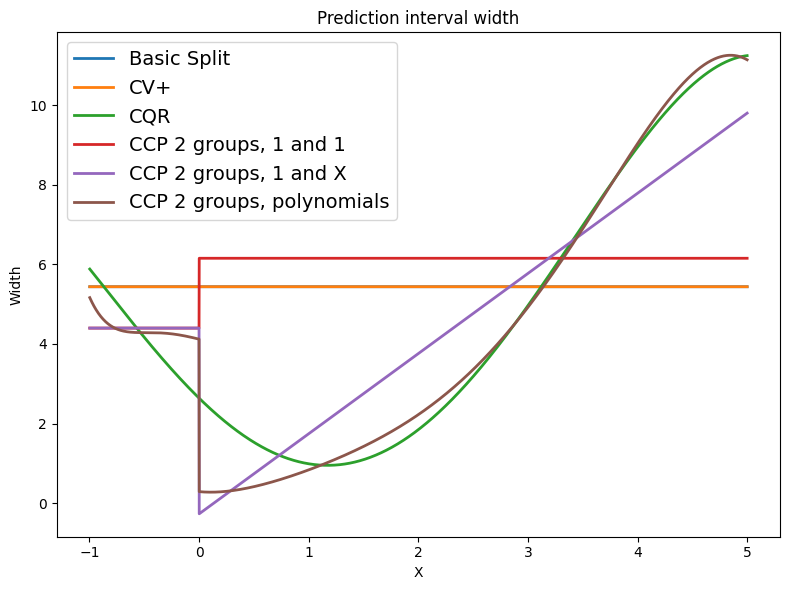

In [15]:
# # ================== CCP 1  ==================
mapie_ccp_1 = SplitCPRegressor(estimator, calibrator=calibrator1, alpha=ALPHA, random_state=random_state)
mapie_ccp_1.fit(X_train, y_train)
y_pred_ccp_1, y_pi_ccp_1 = mapie_ccp_1.predict(X_test)

# # ================== CCP 2  ==================
mapie_ccp_2 = SplitCPRegressor(estimator, calibrator=calibrator2, alpha=ALPHA, random_state=random_state)
mapie_ccp_2.fit(X_train, y_train)
y_pred_ccp_2, y_pi_ccp_2 = mapie_ccp_2.predict(X_test)

# # ================== CCP 3  ==================
mapie_ccp_3 = SplitCPRegressor(estimator, calibrator=calibrator3, alpha=ALPHA, random_state=random_state)
mapie_ccp_3.fit(X_train, y_train)
y_pred_ccp_3, y_pi_ccp_3 = mapie_ccp_3.predict(X_test)

mapies = [mapie_split, mapie_cv, mapie_cqr, mapie_ccp_1, mapie_ccp_2, mapie_ccp_3]
y_preds = [y_pred_split, y_pred_cv, y_pred_cqr, y_pred_ccp_1, y_pred_ccp_2, y_pred_ccp_3]
y_pis = [y_pi_split, y_pi_cv, y_pi_cqr, y_pi_ccp_1, y_pi_ccp_2, y_pi_ccp_3]
titles = ["Basic Split", "CV+", "CQR", "CCP 2 groups, 1 and 1", "CCP 2 groups, 1 and X", "CCP 2 groups, polynomials"]

plot_figure(mapies, y_preds, y_pis, titles)
plot_widths(titles, y_pis)

## 3/ Improve the performances without prior knowledge : <u>CCP as gaussian distances </u>

In [16]:
calibrator_gauss2 = GaussianCCP([[i] for i in range(-1, 6)], 1)
calibrator_gauss3 = GaussianCCP(30, 0.1, random_sigma=True, normalized=True)

# # ================== CCP  ==================
mapie_ccp = SplitCPRegressor(estimator, alpha=ALPHA, cv=pred_cv)
mapie_ccp.fit(X_train, y_train, reg_param=1e-3)
y_pred_ccp, y_pi_ccp = mapie_ccp.predict(X_test)

# # ================== CCP 2  ==================
mapie_ccp_2 = SplitCPRegressor(estimator, calibrator=calibrator_gauss2, alpha=ALPHA, random_state=random_state)
mapie_ccp_2.fit(X_train, y_train)
y_pred_ccp_2, y_pi_ccp_2 = mapie_ccp_2.predict(X_test)

# # ================== CCP 3  ==================
mapie_ccp_3 = SplitCPRegressor(estimator, calibrator=calibrator_gauss3, alpha=ALPHA, random_state=random_state)
mapie_ccp_3.fit(X_train, y_train)
y_pred_ccp_3, y_pi_ccp_3 = mapie_ccp_3.predict(X_test)


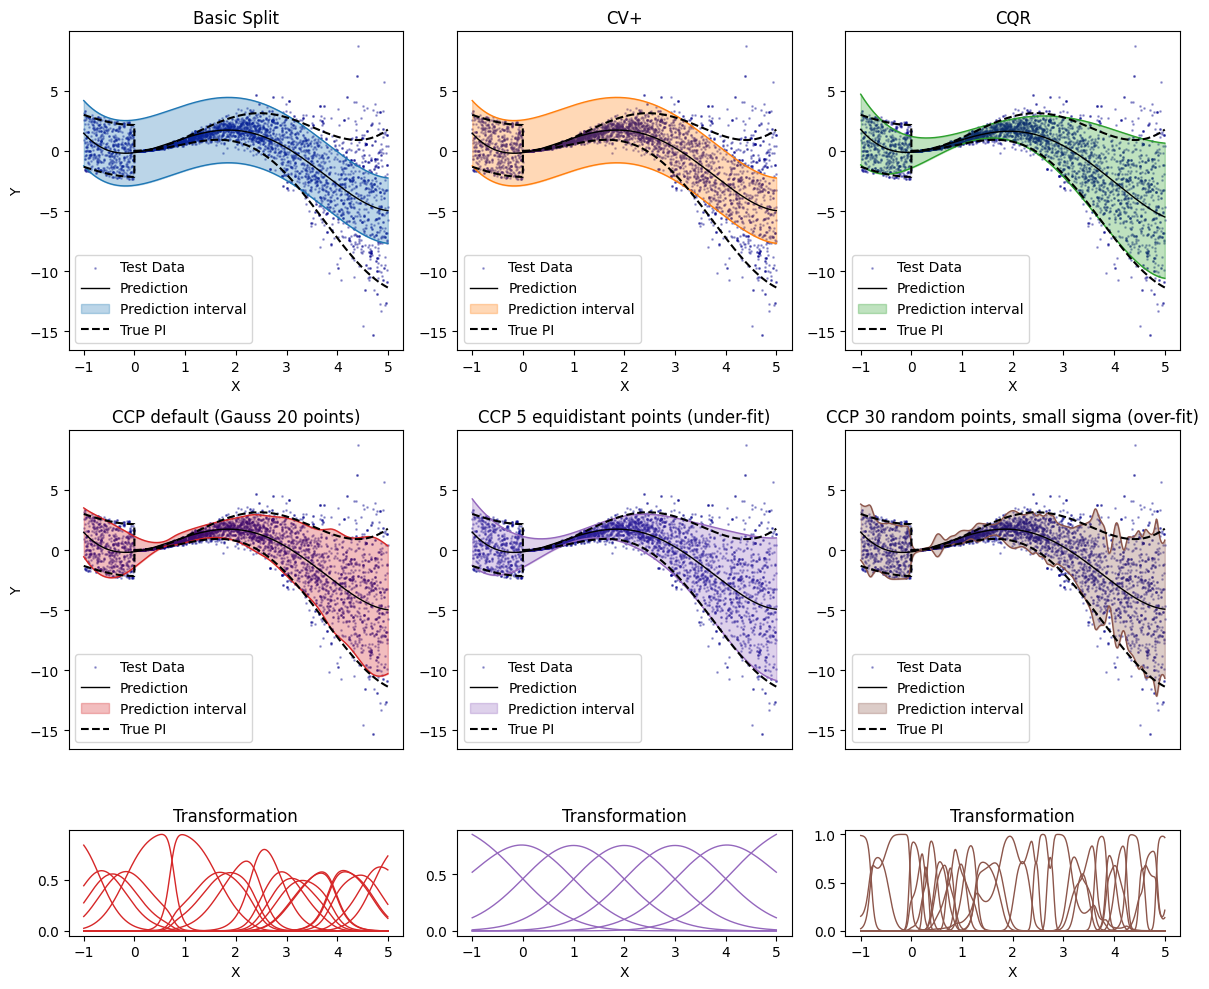

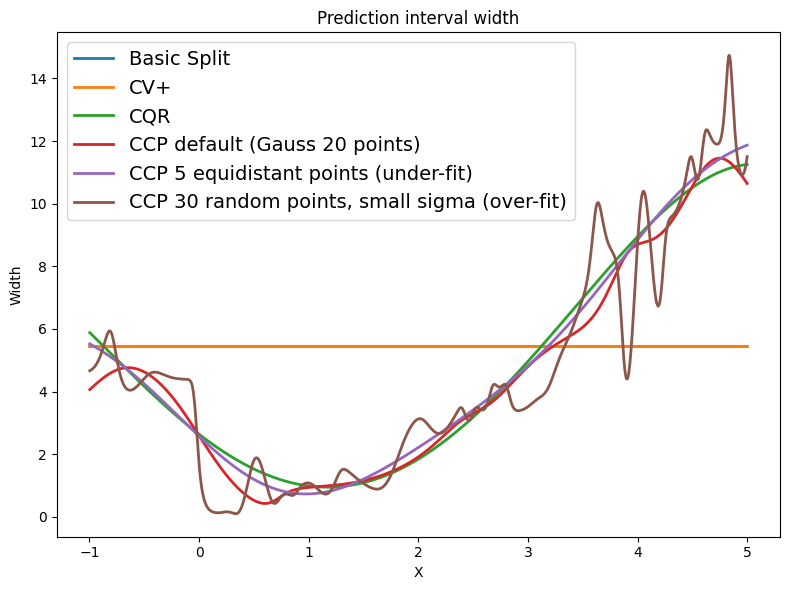

In [17]:
mapies = [mapie_split, mapie_cv, mapie_cqr, mapie_ccp, mapie_ccp_2, mapie_ccp_3]
y_preds = [y_pred_split, y_pred_cv, y_pred_cqr, y_pred_ccp, y_pred_ccp_2, y_pred_ccp_3]
y_pis = [y_pi_split, y_pi_cv, y_pi_cqr, y_pi_ccp, y_pi_ccp_2, y_pi_ccp_3]
titles = ["Basic Split", "CV+", "CQR", "CCP default (Gauss 20 points)", "CCP 5 equidistant points (under-fit)", "CCP 30 random points, small sigma (over-fit)"]

plot_figure(mapies, y_preds, y_pis, titles, show_transform=True)
plot_widths(titles, y_pis)

#### Using gaussian distances from randomly sampled points is a good solution to how an overall good adaptativity.
$\to$ We just need to find the good standard deviation parameters to have a good trade-off between adaptativity and overfitting.